### Question 1: What are the 5 most popular trips that you would call "commuter trips"? 

In the bike rental business, recurring business is important. Commuter trips offer that recurring business as by the nature of work people have to move from their homes to their places of work. Commuter trips could have the following characteristics:

1. The start and end station are not the same. 
2. They occur during peak hours and weekdays
3. They are greater than 1 min.

In [173]:
%%bigquery commuter_trips_top_5

# Map the day of the week number to strings.
CREATE TEMPORARY FUNCTION dayOfWeek(x TIMESTAMP) AS(  ['Sun','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']      [ORDINAL(EXTRACT(DAYOFWEEK from x))]);

# Creating a filtered table with trip duration greater than 60 seconds, trip day is a weekday and start time is the top 6 commuting hours. 
WITH filtered_bikeshare_trips AS (
    SELECT start_station_name, end_station_name, duration_sec, trip_id, start_station_id
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE duration_sec >= 61 AND EXTRACT(HOUR from start_date) IN (
# Subquery to selected top 6 commuter hours. This results in three morning hours and three evening hours
        SELECT start_hour FROM (
            SELECT EXTRACT(HOUR from start_date) AS start_hour,
            COUNT(trip_id) as num_trips
            FROM `bigquery-public-data.san_francisco.bikeshare_trips`
            GROUP BY start_hour
            ORDER BY num_trips DESC LIMIT 6
)) AND dayOfWeek(start_date) IN UNNEST(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
)
# Query to select the start and end stations where the start and end station are not the same. They stations are ordered by the number of trips and limited to top 5
SELECT start_station_name, end_station_name, start_station_id, count(trip_id) as num_trips
FROM filtered_bikeshare_trips
Where start_station_name <> end_station_name
GROUP BY start_station_name, end_station_name, start_station_id
ORDER BY num_trips DESC
LIMIT 5;


Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.69rows/s]


In [174]:
commuter_trips_top_5

,start_station_name,end_station_name,start_station_id,num_trips
0,2nd at Townsend,Harry Bridges Plaza (Ferry Building),61,5165
1,Harry Bridges Plaza (Ferry Building),2nd at Townsend,50,5127
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,69,5040
3,Embarcadero at Sansome,Steuart at Market,60,4904
4,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),51,4756


The commuter trips are 
* 2nd at Townsend to Harry Bridges Plaza (Ferry Building) with 5165 trips
* Harry Bridges Plaza (Ferry Building) to 2nd at Townsend with 5127 trips
* San Francisco Caltrain 2 (330 Townsend) to Townsend at 7th with 5040 trips
* Embarcadero at Sansome to Steuart at Market with 4904
* Embarcadero at Folsom to San Francisco Caltrain (Townsend at 4th) with 4756 trips


### Question 2: What are your recommendations for offers (justify based on your findings)?

To recommend offers, I first want to understand the types of customers that we have and their behvaior patterns. On the website, https://www.lyft.com/bikes/bay-wheels, there are three main types of customers - Monthly, Daily and One Ride Customers. In the database, we see that data is captured by mainly with two main types of users - Subscribers and Customers. Subscriber can be annual or 30-day member; Customer can be 24-hour or 3-day member. I can understand the behaviour of the users at the level of Subscriber or Customer. I can also look to understand the motivations of the Users. We can explore to see if the motivation is to commute to work, run errands or sightsee. 

Secondly to recommend offers, I could take a look at the time-related supply and demand at stations. Since I know the peaktime and downtime of usage through the historical data, we could capitalize on that to provide offers at the stations where the supply is abunduntly available. 

Also note that the recommendations are based on historical analysis of the data and there is no real-time recommendation on offers. The offers cannot be individualized as we not have data at the user level. The analysis is done using the current dataset and external databases have not been brought in the analysis.

#### Understanding user behaviour

To understand user behavior, I need to see if there are differences in how different user types engage with us. The difference could be in the day and time of the day, duration of the trips, and type of the trips. To dig deeper, I would make some observations and analyze them through data.

*Theory 1: Subscribers would use the service on weekdays while Customers would use the service on Weekends

*Theory 2: Subscribers would use for smaller durations as compared to Customers. 

*Theory 3: Subscribers would use the service for commuter trips.

#### Understanding time related supply and demand at stations. 

The nature of business is such that if the inventory remains idle, 

*Theory 4: The bikes are idle at night and non peak hours. 

*Theory 5: The utilization of bikes is uneven across stations. 

*Theory 6: There are some stations were supply is constant indicating that demand is not present.

#### Recommendations

After understanding user behaviour patterns and supply-demand patterns, I would like to make the following recommendations:

1. Incentivise the users that are customers (daily/trip-based plan) and use the service during peak hours to upgrade to Subscribers (Monthly/Yearly plan) by offering them subsidized subscriber plans. 
2. Incentivise the users to use the service on Saturday and Sunday when the demand is low. Overall, if the trip duration is longer during the weekend as compared to the weekdays. Depending on the business and operational objectives, users can be incentivized to make shorter trips on weekends.
3. Among all the weekdays, the usage on Fridays is the least among both the user types. Provide discounted price to Customer Segments to increase the usage on Fridays. 
4. Provide introductory mailers to new users to use services at the station where the availability is high in terms of the absolute average number of bikes available or the percentage of bikes_available is higher than 60%. Such stations are outlined in the description below.

The reasoning behind the recommendations is shown in the sql queries and descriptions below. Each recommendation is derived through the careful analysis of three datasets - 
* bikeshare_trips - The event based data that has 983648 trips from 2013-08-29 to 2016-08-31. 
* bikeshare_stations - There are 74 unique stations that were installed between 2013-08-05 to 2016-08-04.
* bikeshare_status - There are 75 unique stations where the status of the bikes and docks is maintianed between 2013-08-29 and 2016-08-31.  

Do Subscribers use the service on weekdays while Customers use the service on Weekends? Do Subscribers have higher trip duration than Customers?  To answer this, we build the following query to see patterns.
    

In [111]:
%%bigquery Observation_1

CREATE TEMPORARY FUNCTION dayOfWeek(x TIMESTAMP) AS(  ['Sun','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']      [ORDINAL(EXTRACT(DAYOFWEEK from x))]);

SELECT subscriber_type, dayOfWeek(start_date) as day_of_week , COUNT(trip_id) as trips, avg(duration_sec) / 60 AS minutes
FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
Where duration_sec >= 61 AND duration_sec <= 8 * 60 *60
group by day_of_week, subscriber_type
Order by trips DESC

Downloading: 100%|██████████| 14/14 [00:01<00:00,  8.50rows/s]


In [112]:
Observation_1

,subscriber_type,day_of_week,trips,minutes
0,Subscriber,Tue,169556,8.985598
1,Subscriber,Wed,165421,9.036686
2,Subscriber,Thu,160218,9.042957
3,Subscriber,Mon,154673,8.966808
4,Subscriber,Fri,139944,9.098199
5,Subscriber,Sat,31004,9.839889
6,Customer,Sat,28820,49.363111
7,Customer,Sun,25552,51.036323
8,Subscriber,Sun,25434,10.091692
9,Customer,Fri,19681,42.770449


In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

array([<AxesSubplot:title={'center':'trips'}, xlabel='subscriber_type'>,
       <AxesSubplot:title={'center':'minutes'}, xlabel='subscriber_type'>],
      dtype=object)

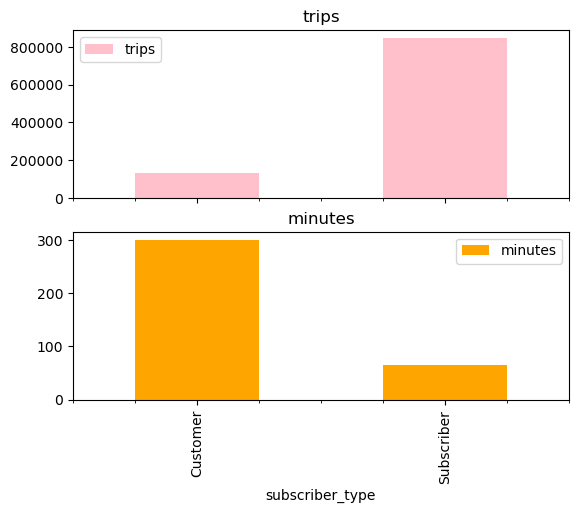

In [228]:
Observation_1.groupby('subscriber_type').sum().plot.bar(color={'trips': 'pink', 'minutes': 'orange'}, subplots=True)

array([<AxesSubplot:title={'center':'trips'}, xlabel='day_of_week'>,
       <AxesSubplot:title={'center':'minutes'}, xlabel='day_of_week'>],
      dtype=object)

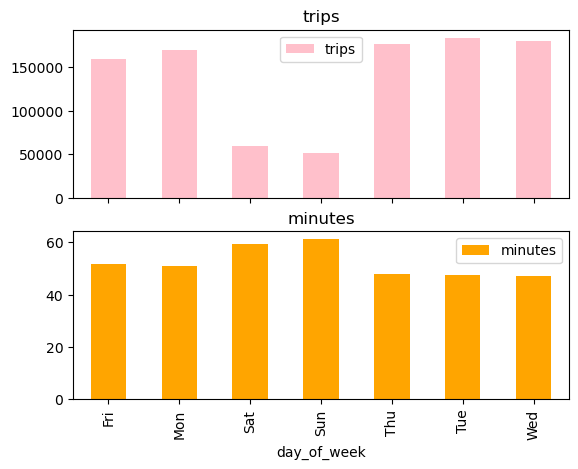

In [229]:
Observation_1.groupby('day_of_week').sum().plot.bar(color={'trips': 'pink', 'minutes': 'orange'}, subplots=True)

##### Observation 1 and 2

From the table and graphs, we can notice that Customers generally use the service on Saturday and Sunday. Subscribers use it on weekdays the most. I observe that Subscribers also use it on Saturday. However subscribers do not use the service as much on Sunday. One recommendation is to provide offers to Subscribers on Sunday to increase the usage of bikes. Overall, the least usage is on Sunday. From the table and graphs, we notice that average trip duration is higher during weekends as compared to weekdays. Overall customers have higher average duration as compared to subscribers. 

##### Do Subscribers use the service for commuter trips more than Customers?

From the queries below we query the table first for only commuter trips. Next in the filtered table, I would like to see if the proportion of Customer is lower than Subscribers.

In [212]:
%%bigquery all_commuter_trips

CREATE TEMPORARY FUNCTION dayOfWeek(x TIMESTAMP) AS(  ['Sun','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']      [ORDINAL(EXTRACT(DAYOFWEEK from x))]);

WITH filtered_bikeshare_trips AS (
    SELECT start_station_name, end_station_name, duration_sec, trip_id, subscriber_type, bike_number, start_date, end_date
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    WHERE duration_sec >= 61 AND EXTRACT(HOUR from start_date) IN (
        SELECT start_hour FROM (
            SELECT EXTRACT(HOUR from start_date) AS start_hour,
            COUNT(trip_id) as num_trips
            FROM `bigquery-public-data.san_francisco.bikeshare_trips`
            GROUP BY start_hour
            ORDER BY num_trips DESC LIMIT 6
)) AND dayOfWeek(start_date) IN UNNEST(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
)
SELECT start_station_name, end_station_name, trip_id, duration_sec, subscriber_type, bike_number, start_date, end_date
FROM filtered_bikeshare_trips
Where start_station_name <> end_station_name

Downloading: 100%|██████████| 554128/554128 [00:01<00:00, 342197.93rows/s]


<AxesSubplot:xlabel='subscriber_type'>

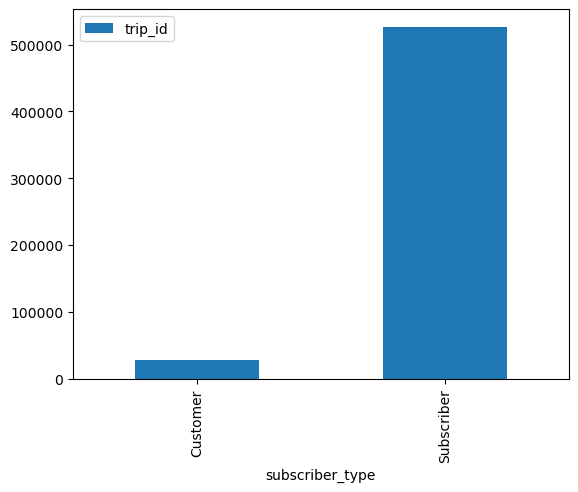

In [121]:
all_commuter_trips.filter(items=['subscriber_type', 'trip_id', 'duration_sec']).groupby('subscriber_type').count().plot(kind='bar')

From the query and table above, I notice that the theory that most commuters would be Subscribers seems to be correct. Here we also notice that there are some users of type Customers that take commuter trips. There is a possibility to upsell the Customer to Subscriber model. The explaination is shown in the charts below

##### Observation 5: Finding the top stations where there is high availability of bikes on average.

The following query aggregates the average bikes available by station id and day of the week. The output is sorted by the bike availability for the top 100.  

In [248]:
%%bigquery bikeshare_status

# Finding the top stations where the most bikes are available.

SELECT a.station_id, 
avg(bikes_available) as avg_bikes_available,
avg(docks_available) as avg_docks_available,
name, landmark
FROM `bigquery-public-data.san_francisco.bikeshare_status` a inner join `bigquery-public-data.san_francisco.bikeshare_stations` b on
a.station_id = b.station_id
GROUP BY 1,4,5
ORDER BY 2 DESC
LIMIT 25

Downloading: 100%|██████████| 25/25 [00:01<00:00, 16.97rows/s]


<AxesSubplot:xlabel='station_id'>

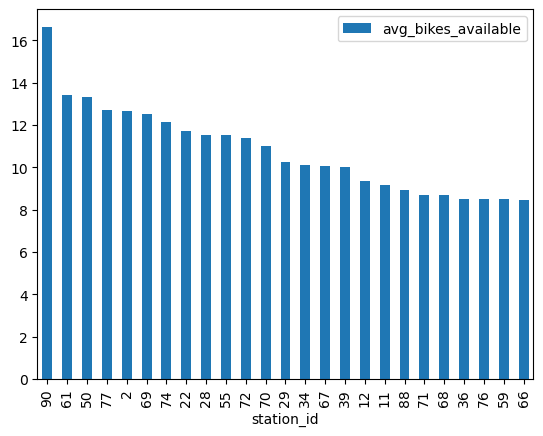

In [250]:
bikeshare_status.plot(x= "station_id", y = "avg_bikes_available", kind="bar")

In [251]:
bikeshare_status.name

0                               5th St at Folsom St
1                                   2nd at Townsend
2              Harry Bridges Plaza (Ferry Building)
3                                 Market at Sansome
4                 San Jose Diridon Caltrain Station
5           San Francisco Caltrain 2 (330 Townsend)
6                                 Steuart at Market
7                     Redwood City Caltrain Station
8                    Mountain View Caltrain Station
9     Temporary Transbay Terminal (Howard at Beale)
10                Civic Center BART (7th at Market)
11         San Francisco Caltrain (Townsend at 4th)
12                     San Antonio Caltrain Station
13                       Palo Alto Caltrain Station
14                                   Market at 10th
15                               Powell Street BART
16                           SJSU 4th at San Carlos
17                                      MLK Library
18                     5th S. at E. San Salvador St
19          

The above mentioned stations have the highest number of bike availability on average. Since the inventory is just suitting there on average, we could attract new users that can utlize these bike stations. 

##### Observation: Check the average availability of bikes over the hours. My theory is that during non peak hours the availability of the bikes should increase accross all stations across all days. 

The query below gets the average availability of the bikes grouped by the hour and month 

In [281]:
%%bigquery bikeshare_status_hours

SELECT Extract(hour from time) as status_hour,
avg(bikes_available) as avg_bikes_available
FROM `bigquery-public-data.san_francisco.bikeshare_status`
GROUP BY 1
ORDER BY 2 DESC

Downloading: 100%|██████████| 24/24 [00:01<00:00, 18.97rows/s]


<AxesSubplot:xlabel='status_hour'>

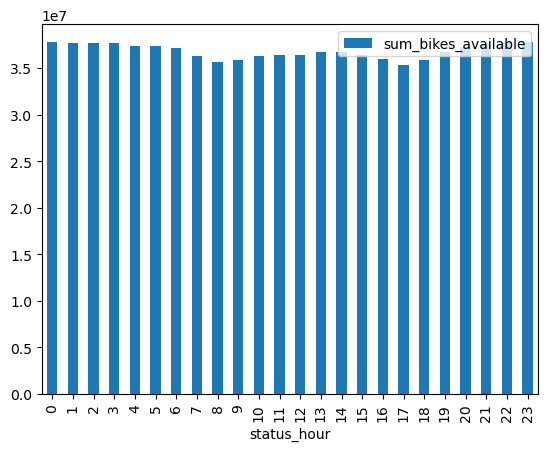

In [282]:
bikeshare_status_hours.sort_values('status_hour').plot(x='status_hour', y = 'sum_bikes_available', kind = 'bar')

Overall there are same number of avg bikes available during all the hours of the day across all stations. So there is no reasonable hour at which we could send offers. Our theory of The bikes are idle at night and non peak hours does not have merit. 

##### Now we try to find the bike stations where percentage utilization is very low. A proxy for percetage utlization could be the number of bike available upon the maximum number of bike available at that station. 

The below query finds the top 25 stations ids where the bike availability is the highest.

In [286]:
%%bigquery bikeshare_top25_bike_availability

SELECT station_id,
avg(bikes_available)/max(bikes_available) * 100 as pct_bikes,
avg(docks_available) as avg_docks_available,
FROM `bigquery-public-data.san_francisco.bikeshare_status`
GROUP BY 1
HAVING max(bikes_available) > 0
ORDER BY 2 DESC LIMIT 25

Downloading: 100%|██████████| 25/25 [00:01<00:00, 17.03rows/s]


In [290]:
bikeshare_top25_bike_availability[bikeshare_top25_bike_availability['pct_bikes'] > 50]

,station_id,pct_bikes,avg_docks_available
0,88,81.273640,10.023536
1,89,63.650705,13.265064
2,50,57.981858,9.576255
3,70,57.837759,7.936394
4,90,57.393914,14.338156
5,36,56.656871,6.483567
6,54,55.542071,6.628407
7,3,54.730211,6.779045
8,69,54.473921,10.396655
9,35,54.368264,5.004499


There some stations where the percentage availability is higher than 50% during the time frame. We could provide offers to incentivise users to use these stations where percentage availability is higher. The above list is the one that we could use to send offers.